## Installing Qiskit


1. First of all, you need to install Python on your device (https://wiki.python.org/moin/BeginnersGuide/Download)

2. It is recommended that you create a separate virtual environment to run Qiskit (https://docs.python.org/3.10/tutorial/venv.html)

3. Once you create the virtual environment to run Qiskit, activate the environment to install necessary packages.

4. Install Qiskit SDK using:

```python
pip install qiskit

pip install qiskit-ibm-runtime
```


5. If you want to run a Jupyter notebook, you will need to install Jupyter in your environment as well. 

```python
pip install jupyter
```

and open your notebook with:

```python
jupyter notebook path/to/notebook.ipynb
```

6. You can also download and use VS Code (https://code.visualstudio.com/download)


Instructions from the page (https://docs.quantum.ibm.com/start/install)

A detailed video instructions can be found here https://www.youtube.com/watch?v=dZWz4Gs_BuI

## Set up an IBM Quantum channel


IBM offers access to quantum computers via open access plan. 

Since we have already set up our environment for Qiskit and Qiskit Runtime, now we need to create an IBM Quantum account.

1. Go to the page https://quantum.ibm.com/ and create an account by clicking on **"Create an IBMid"** and following the instructions.

2. You will be prompted to a screen to enter your email and other basic information, then verify your email address.

3. Your user account is associated with one or more access instances (in the form hub / group / project) that give access to IBM Quantum services. Additionally, a unique token is assigned to each account, allowing for IBM Quantum access from Qiskit.

4. When you log into your IBM Quantum account page, you will be able to copy your unique API token associated with your account.

5. Authenticate to the service by calling QiskitRuntimeService with your IBM Quantum API key and CRN:

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")

Or, optionally use the save_account() method to save your credentials for easy access later on, before initializing the service.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", set_as_default=True)
 
# Load saved credentials
service = QiskitRuntimeService()

- If you save your credentials to disk, you can use QiskitRuntimeService() in the future to initialize your account. The channel parameter distinguishes between different account types. If you are saving multiple accounts per channel, consider using the name parameter to differentiate them.

- Credentials are saved to $HOME/.qiskit/qiskit-ibm.json. Do not manually edit this file.

- If you don't save your credentials, you must specify them every time you start a new session.

- The channel parameter allows you to distinguish between different account types. When initializing the account, IBM Cloud is the default account used if have saved credentials for an IBM Quantum Platform and an IBM Cloud account.

Let's test the setup to make sure that everything works correctly!

In [2]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 
# Create empty circuit
example_circuit = QuantumCircuit(2)
example_circuit.measure_all()
 
# You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
 
sampler = Sampler(backend)
job = sampler.run([example_circuit])
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: cs8faqt7yykg0082h9g0
PrimitiveResult([PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'version': 2})


## Building circuits and operators with Qiskit SDK

- The foundation of quantum programs are quantum circuits, which consist of operations - including gates, measurement, and reset - that manipulate qubits in the quantum computer.

- All tasks require building one or more quantum circuits to represent the problem we aim to solve. Some tasks additionally require constructing quantum operators to define properties of quantum states that you want to estimate or measure.

- Qiskit enables working with circuits (and, to some extent, operators) at various abstraction levels: abstract, virtual, physical, scheduled, and pulse programs. At the most abstract level is a task-oriented lens in the circuit library.

- You can also express operations in abstract mathematical terms using operators, isometries, and classical/Boolean functions. For virtual circuits, mathematical abstractions take on a concrete representation in terms of a concrete gate set.

-  At the physical level, those instructions are mapped to specific physical qubits, and instructions are re-written to reflect the connectivity and native gate set of a target hardware platform. Scheduled circuits introduce timing information, and pulse programs represent signals on channels.

# What is a quantum circuit?

A simple quantum circuit is a collection of qubits and a list of instructions that act on those qubits. 

We can create quantum circuits manually by first declaring the number of qubits in the ciruit, then adding the quantum gates we would like to include

In [1]:
from qiskit import QuantumCircuit
 
qc = QuantumCircuit(2)
qc.qubits

[Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)]

Adding an instruction to the circuit appends the instruction to the circuit's data attribute. The following cell output shows data is a list of "Circuit Instruction" objects, each of which has an operation attribute, and a qubits attribute.

In [2]:
qc.x(0)  # Add X-gate to qubit 0
qc.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())]

The easiest way to view this information is through the draw method, which returns a visualization of a circuit.

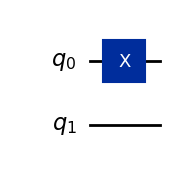

In [3]:
qc.draw("mpl")

To combine two circuits, use the compose method. This accepts another QuantumCircuit and an optional list of qubit mappings.

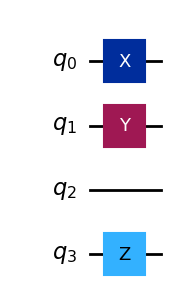

In [4]:
qc_a = QuantumCircuit(4)
qc_a.x(0)
 
qc_b = QuantumCircuit(2, name="qc_b")
qc_b.y(0)
qc_b.z(1)
 
# compose qubits (0, 1) of qc_a to qubits (1, 3) of qc_b respectively
combined = qc_a.compose(qc_b, qubits=[1, 3])
combined.draw("mpl")

# Parameterized circuits

Many near-term quantum algorithms involve executing many variations of a quantum circuit. Since constructing and optimizing large circuits can be computationally expensive, Qiskit supports parameterized circuits. These circuits have undefined parameters, and their values do not need to be defined until just before executing the circuit. This lets you move circuit construction and optimization out of the main program loop. The following cell creates and displays a parameterized circuit.

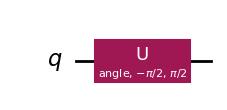

In [5]:
from qiskit.circuit import Parameter
angle = Parameter("angle")  # undefined number
 
# Create and optimize circuit once
qc = QuantumCircuit(1)
qc.rx(angle, 0)
 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
qc = generate_preset_pass_manager(optimization_level=3, basis_gates=['u', 'cx']).run(qc)
 
qc.draw("mpl")

The following cell creates many variations of this circuit and displays one of the variations.

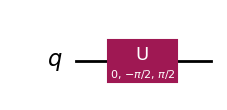

In [8]:
circuits = []
for value in range(100):
    circuits.append(
        qc.assign_parameters({ angle: value })
    )
 
circuits[0].draw("mpl")

# Circuit library

The Qiskit SDK includes a library of popular circuits to use as building blocks in your own programs. Using pre-defined circuits saves time researching, writing code, and debugging. The library includes popular circuits in quantum computing, circuits that are difficult to simulate classically, and circuits useful for quantum hardware benchmarking.

# Standard gates

The circuit library also includes standard quantum gates. Some are more fundamental gates (such as the UGate), and others are multi-qubit gates that usually need building from single- and two-qubit gates. To add imported gates to your circuit, use the append method; the first argument is the gate, and the next argument is a list of qubits to apply the gate to.

For example, the following code cell creates a circuit with a Hadamard gate and a multi-controlled-X gate.

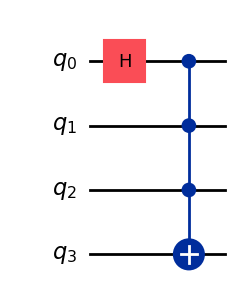

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, MCXGate
mcx_gate = MCXGate(3)
hadamard_gate = HGate()
 
qc = QuantumCircuit(4)
qc.append(hadamard_gate, [0])
qc.append(mcx_gate, [0,1,2,3])
qc.draw('mpl')

# N-local circuits

These circuits alternate layers of single-qubit rotation gates with layers of multi-qubit entangling gates.

This family of circuits is popular in variational quantum algorithms because they can produce a wide range of quantum states. Variational algorithms adjust the gate parameters to find states that have certain properties (such as states that represent a good solution to an optimization problem). For this purpose, many circuits in the library are parameterized, which means you can define them without fixed values.

The following code cell imports a TwoLocal circuit, in which the entangling gates are two-qubit gates. This circuit interleaves blocks of parameterized single-qubit gates, followed by entangling blocks of two-qubit gates.

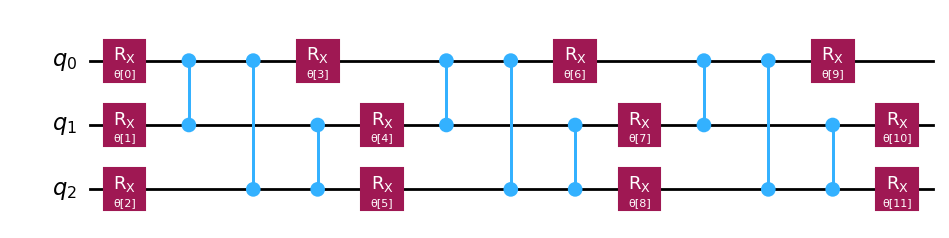

In [10]:
from qiskit.circuit.library import TwoLocal

two_local = TwoLocal(3, 'rx', 'cz')
two_local.decompose().draw('mpl')

You can also assign these parameters to real values using a dictionary of the form { Parameter: number }. To demonstrate, the following code cell assigns each parameter in the circuit to 0.

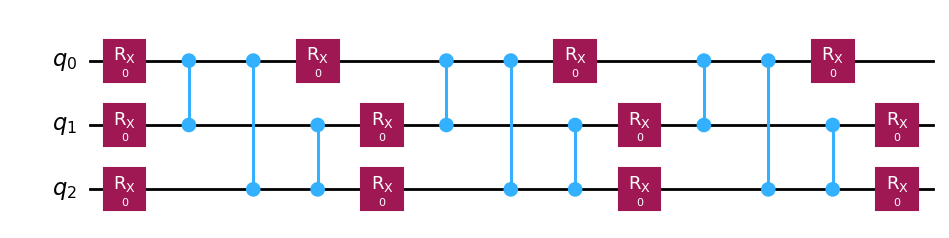

In [11]:
bound_circuit = two_local.assign_parameters({ p: 0 for p in two_local.parameters})
bound_circuit.decompose().draw('mpl')

# Data-encoding circuits

These parameterized circuits encode data onto quantum states for processing by quantum machine learning algorithms. Some circuits supported by Qiskit are:

- Amplitude encoding, which encodes each number into the amplitude of a basis state. This can store $2^n$ numbers in a single state, but can be costly to implement.

- Basis encoding, which encodes an integer 𝑘 by preparing the corresponding basis state ∣k⟩.

- Angle encoding, which sets each number in the data as a rotation angle in a parameterized circuit.

The best approach depends upon the specifics of your application. On current quantum computers, however, we often use angle-encoding circuits such as the ZZFeatureMap.

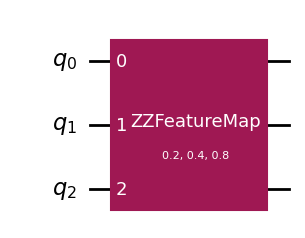

In [12]:
from qiskit.circuit.library import ZZFeatureMap
 
features = [0.2, 0.4, 0.8]
feature_map = ZZFeatureMap(feature_dimension=len(features))
 
encoded = feature_map.assign_parameters(features)
encoded.draw('mpl')

There are many other circuits in the library such as:

- Time-evolution circuits
- Benchmarking and complexity-theory circuits
- Arithmetic circuits

More information in Qiskit documentation: https://docs.quantum.ibm.com/build/circuit-library

# Specify observables in the Pauli basis

In quantum mechanics, observables correspond to physical properties that can be measured. When considering a system of spins, for example, you could be interested in measuring the system's energy or obtaining information about the alignment of the spins, such as the magnetization or the correlations between spins.

To measure an n-qubit observable O on a quantum computer, you must represent it as a sum of tensor products of Pauli operators, that is

$$ O = \sum_{k=1}^K \alpha_k P_k$$ 

where $P_k \in \{ I, X, Y, Z \}^{\otimes n}, \alpha_k \in \mathbb{R}$. The standard Pauli matrices are:

$$ I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$

and you use the fact that an observable is Hermitian, as in $O^\dag = O$, If O is not Hermitian it can still be decomposed as a sum of Paulis, but the coefficient $\alpha_k$ becomes complex.

In many cases, the observable is naturally specified in this representation after mapping the system of interest to qubits. For example, a spin-1/2 system can be mapped to an Ising Hamiltonian,

$$ H = \sum_{<i,j>} Z_i Z_j - \sum_{i=1}^n X_i $$

where the indices ⟨i,j⟩ run over interacting spins and the spins are subject to a transversal field in X. The subscript index indicates which qubit the Pauli operator acts on, i.e. $X_i$ applies an X operator on qubit i and leaves the rest unchanged. In the Qiskit SDK, this Hamiltonian could be constructed as

In [13]:
from qiskit.quantum_info import SparsePauliOp
# define the number of qubits
n = 12
 
# define the single Pauli terms as ("Paulis", [indices], coefficient)
interactions = [("ZZ", [i, i + 1], 1) for i in range(n - 1)]  # we assume spins on a 1D line
field = [("X", [i], -1) for i in range(n)]
 
# build the operator
hamiltonian = SparsePauliOp.from_sparse_list(interactions + field, num_qubits=n)

For observables that are not given in terms of Pauli operators but in a matrix for, we first have to reformulate them in the Pauli basis in order to evaluate them on a quantum computer. We are always able to find such a representation as the Pauli matrices form a basis for the Hermitian $2^n \times 2^n$ matrices. We expand the observable O as

$$ O = \sum_{P \in \{ I, X, Y, Z \}^{\otimes n}} Tr(OP)P $$

where the sum runs over all possible n-qubit Pauli terms and Tr(⋅) is the trace of a matrix, which acts as inner product. You can implement this decomposition from a matrix to Pauli terms using the SparsePauliOp.from_operator method, like so:

In [14]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
 
matrix = np.array([[-1, 0, 0.5, -1],
		   [0, 1, 1, 0.5],
		   [0.5, 1, -1, 0],
		   [-1, 0.5, 0, 1]])
 
observable = SparsePauliOp.from_operator(matrix)
print(observable)  

SparsePauliOp(['IZ', 'XI', 'YY'],
              coeffs=[-1. +0.j,  0.5+0.j,  1. -0.j])


# Transpilation 

Transpilation is the process of rewriting a given input circuit to match the topology of a specific quantum device, and optimize the circuit instructions for execution on noisy quantum systems.

Qiskit's prebuilt transpiler pipeline consists of six fundamental stages:

1. init - This pass runs any initial passes that are required before we start embedding the circuit to the system. This typically involves unrolling custom instructions and converting the circuit to all single- and two-qubit gates. (By default this will just validate the circuit instructions and translate multi-qubit gates into single- and two-qubit gates.)

2. layout - This pass applies a layout, mapping/assigning the virtual qubits in your circuit to the physical qubits of a system.

3. routing - This pass runs after a layout has been applied and will inject gates (that is, SWAPs) in the original circuit in order to make it compatible with the system's connectivity/coupling map.

4. translation - This pass translates the gates in the circuit to the system's basis set of instructions.

5. optimization - This pass runs an optimization loop to find more efficient decompositions of your quantum circuit until a condition is met (such as a fixed depth).

6. scheduling - This stage is for any hardware-aware scheduling passes. If the user specifies a scheduling method, this stage accounts for all idle time in the circuit.

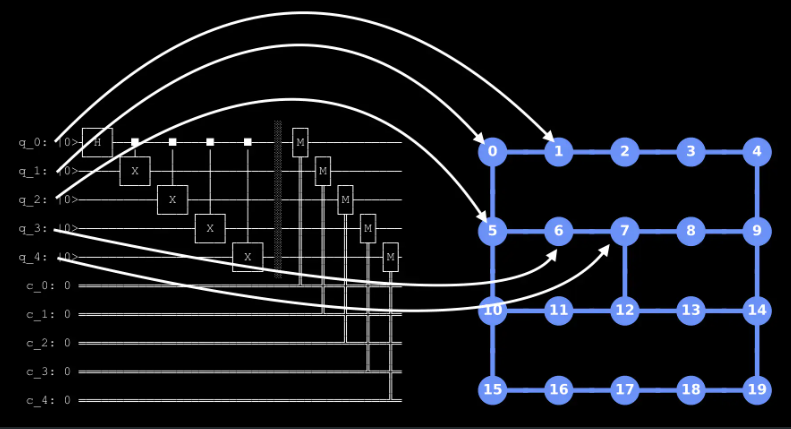

# Transpilation default settings and configuration options

Abstract circuits need to be transpiled because systems have a limited set of basis gates and cannot execute arbitrary operations. The transpiler's function is to change arbitrary circuits so that they can run on a specified system. This is done by translating the circuits to the supported basis gates, and by introducing SWAP gates as needed, so that the circuit's connectivity matches that of the system.

You can create a pass manager using the "generate_preset_pass_manager" function and pass a circuit or list of circuits to its run method to transpile them. You can call "generate_preset_pass_manager" passing only the optimization level and backend, choosing to use the defaults for all other options, or you can pass additional arguments to the function to fine-tune the transpilation.

# Basic usage without parameters

In this example, we pass a circuit and target system to the transpiler without specifying any further parameters.

Create a circuit and view the result:

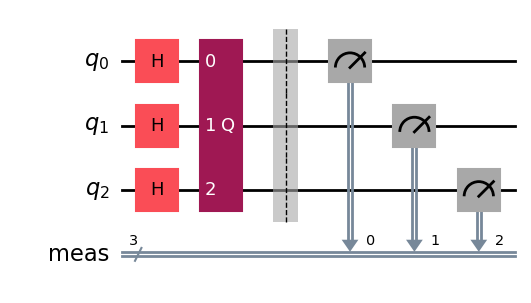

In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, Diagonal
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
 
# Create circuit to test transpiler on
oracle = Diagonal([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0, 1, 2])
qc = qc.compose(GroverOperator(oracle))
 
# Add measurements to the circuit
qc.measure_all()
 
# View the circuit
qc.draw(output='mpl')

Transpile the circuit and view the result:

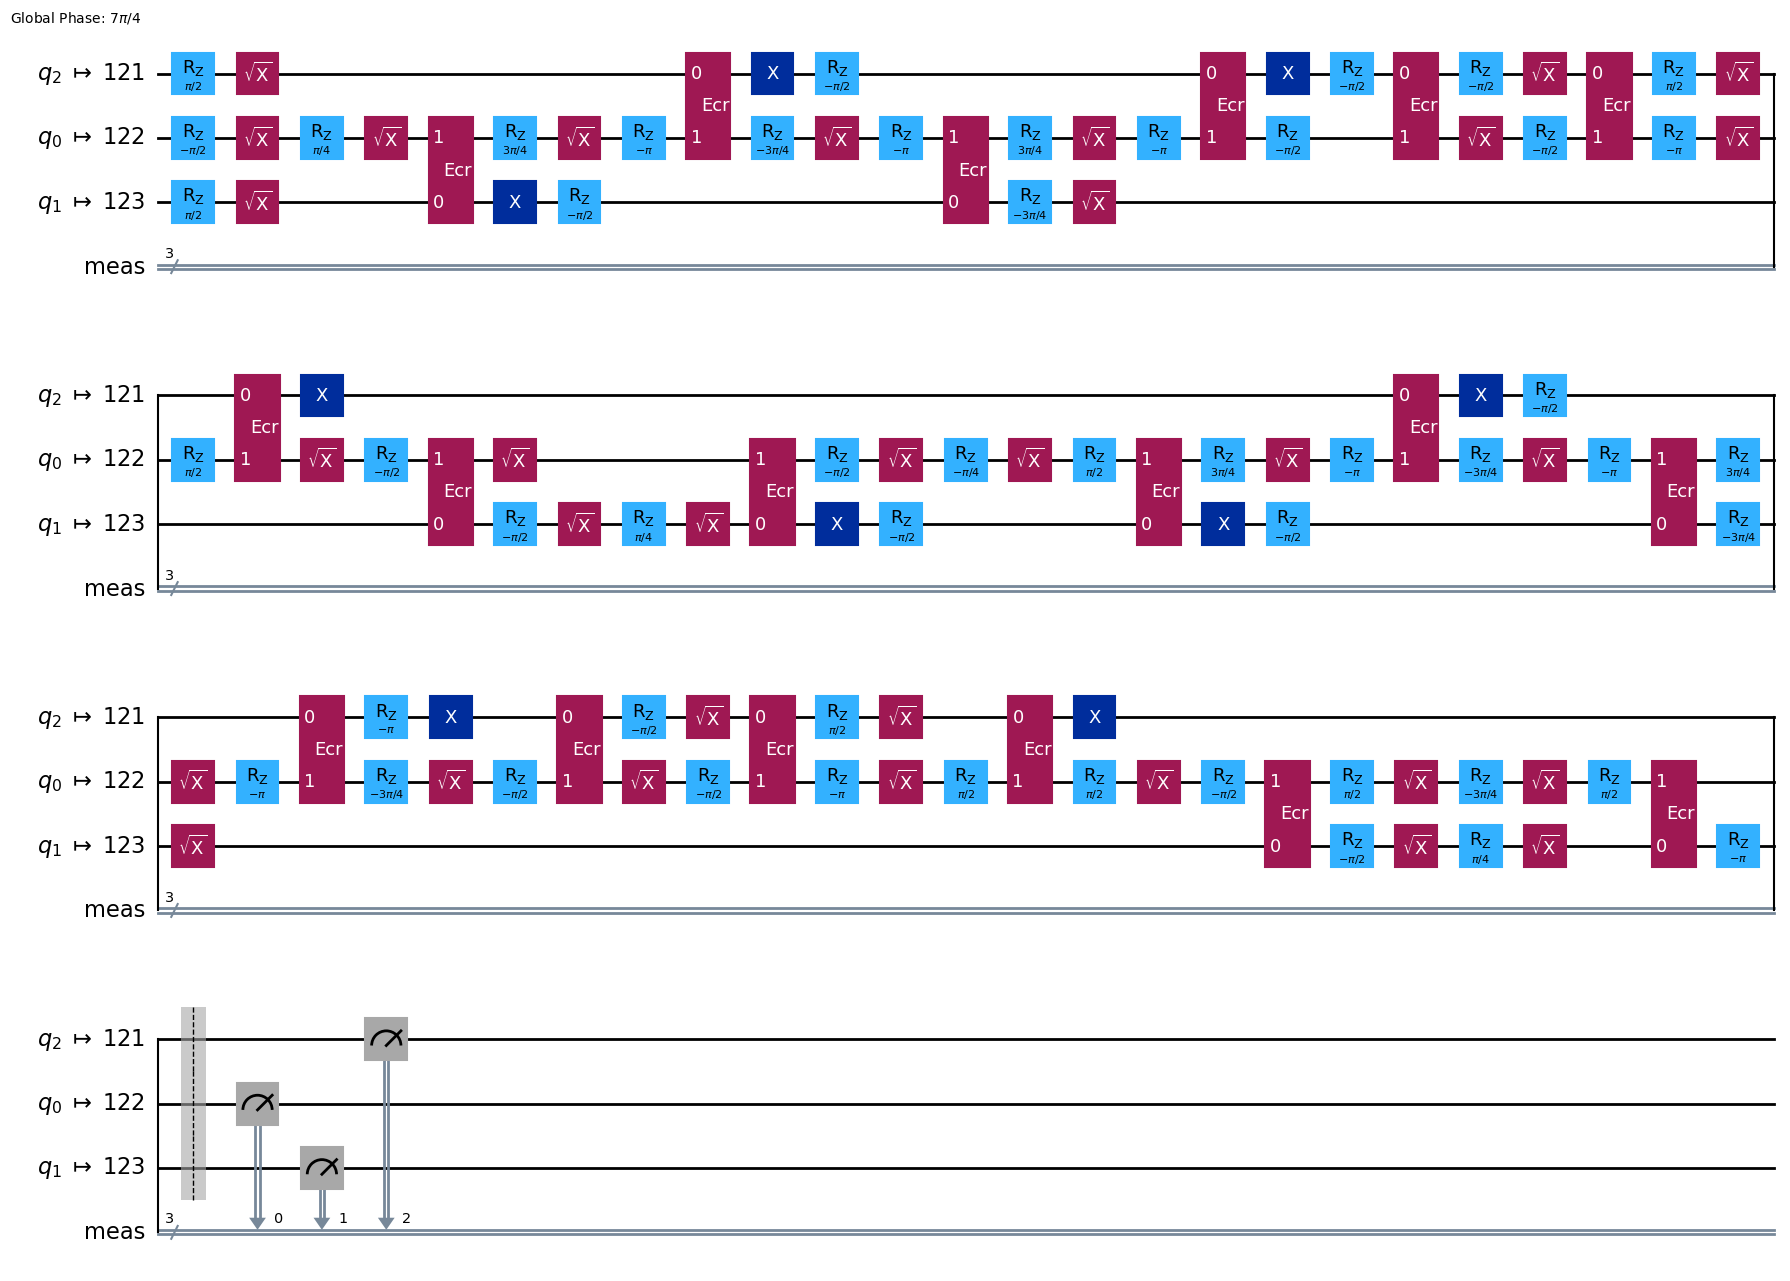

In [16]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
# Specify the system to target
backend = FakeSherbrooke()
 
# Transpile the circuit
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_circ = pass_manager.run(qc)
 
# View the transpiled circuit
transpiled_circ.draw(output='mpl', idle_wires=False)